In [1]:
import pandas as pd
import skimage.io
import os
from pathlib import Path
import matplotlib.pyplot as plt
import ast
import numpy as np
import cv2 as cv
import tensorflow as tf

def clean_empty(x):
    if not x:
        return ''
    else:
        return x

def extract_coords(annotations):
    boxs = []
    if annotations == '':
        return []
    else:
        for annotation in annotations:
            x0 = annotation['x']
            y0 = annotation['y'] 
            w = annotation['width']
            h = annotation['height']
            boxs.append((x0,y0,w,h))
    return boxs

def draw_bbox(img, boxs):
    for box in boxs:
        x0,y0,w,h = box
        x0,y0 = int(x0),int(y0)
        x1 = int(x0+w)
        y1 = int(y0+h)
        img = cv.rectangle(img, (x0, y0), (x1, y1), (0, 0, 255), 2)
    return img

def draw_centroid(img, bboxs):
    for bbox in bboxs:
        xc,yc,w,h = bbox
        xc,yc = int(xc), int(yc)
        img = cv.circle(img, (xc,yc), radius=0, color=(0, 0, 255), thickness=5)
    return img

def bbox_x0y0_to_xcycwh(bboxs):
    transformed_boxs = []
    if bboxs != []:
        for bbox in bboxs:
            x0,y0,w,h = bbox
            xc = x0 + (int(w)/2)
            yc = y0 + (int(h)/2)
            transformed_boxs.append((xc,yc,w,h))
    else:
        transformed_boxs.append(pad_empty_bbox())
    return np.array(transformed_boxs)

def pad_empty_bbox():
    return np.array([0,0,0,0])

In [2]:
df = pd.read_csv('train.csv')

df.annotations = df.annotations.map(lambda x: ast.literal_eval(x))
df.annotations = df.annotations.map(clean_empty)
df['bboxs'] = df['annotations'].map(extract_coords)

df['bboxs'] = df['bboxs'].map(bbox_x0y0_to_xcycwh)

df['class_label'] = df['annotations'].map(lambda x :1 if (x is not '') else 0).astype(np.float32)
df['img_fp'] = df[['video_id','video_frame']].apply(lambda x: f'train_images/video_{x.video_id}/{x.video_frame}.jpg',axis=1)

In [3]:
img_fp,bboxs  = df.query('annotations != ""')[['img_fp','bboxs']].loc[141].values
img = skimage.io.imread(img_fp)

In [4]:
bboxs

array([[678.5, 125. ,  35. ,  38. ]])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


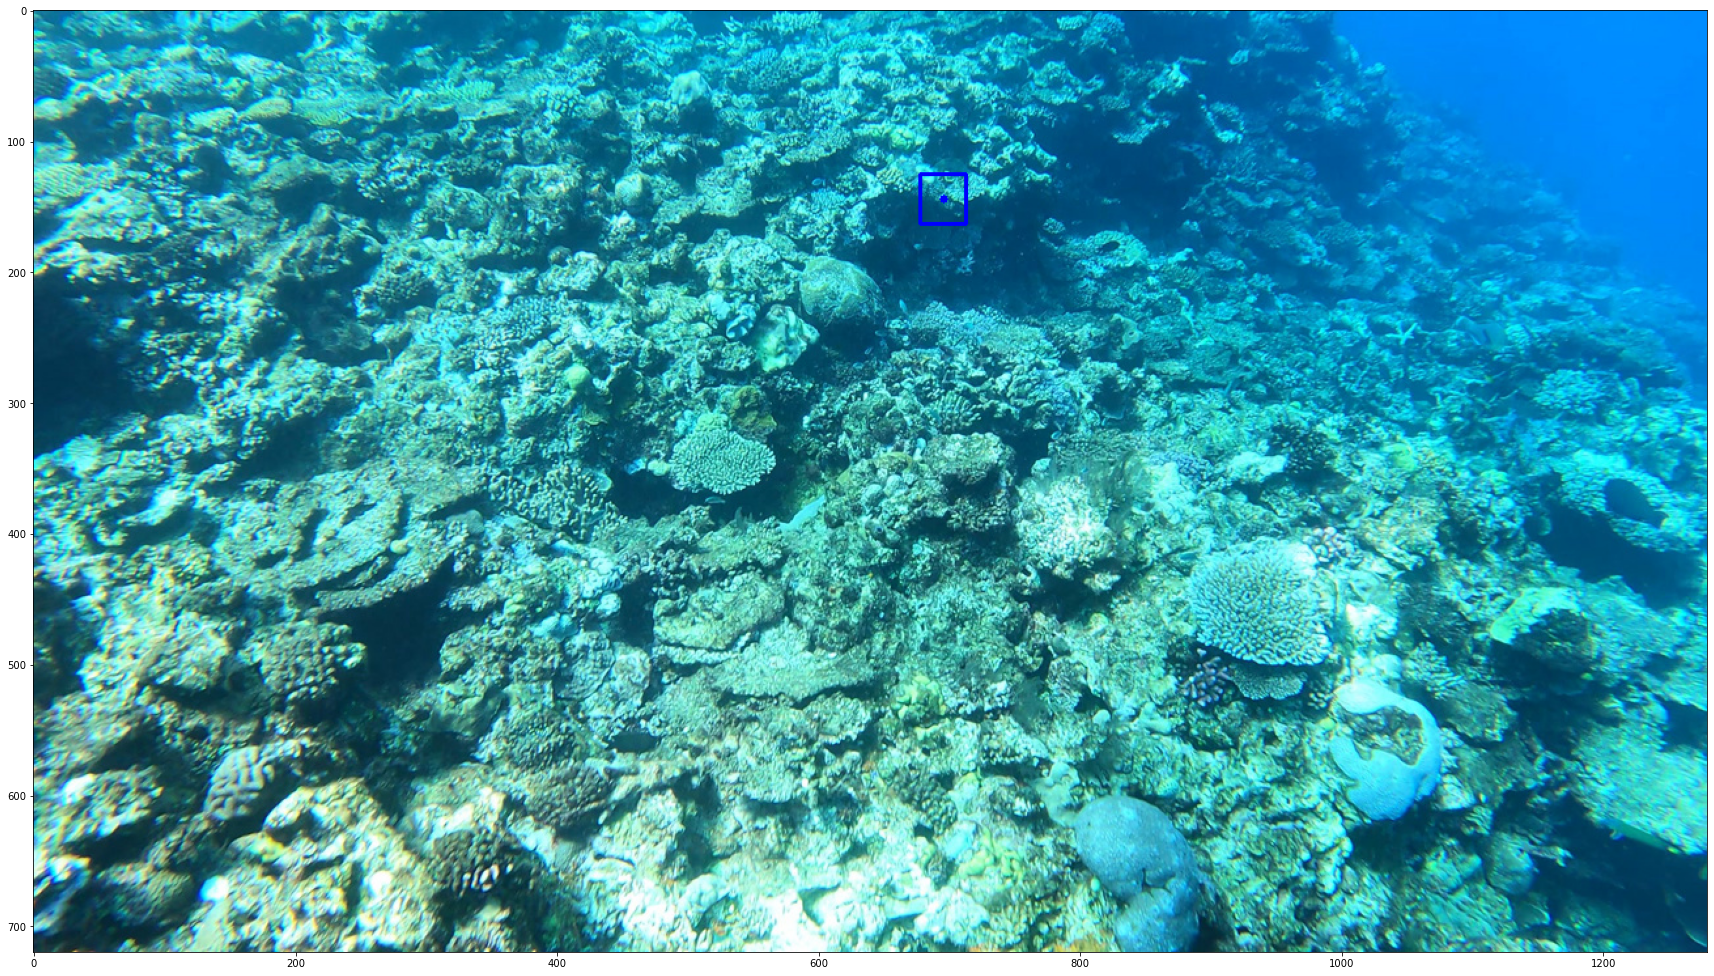

In [5]:
detr_bboxs = bbox_x0y0_to_xcycwh(bboxs)
img = draw_bbox(img,bboxs)
img = draw_centroid(img,detr_bboxs)

plt.figure(figsize = (30,30))
plt.imshow(img)


# Make dataset for training

In [186]:
def load_img_bbox(fp,bboxs, label):
    """
    Read image and bboxs in format of (x0,y0,w,h).
    Transform bboxs to format (xc,yc,w,h)
    """
    bit = tf.io.read_file(fp)
    img = tf.io.decode_jpeg(bit,channels=3)  
   
    return tf.cast(img,tf.float32),tf.cast(bboxs,tf.float32), tf.cast(label,tf.uint8)


def normalise_image_get_bbox(img,bbox, label):
    """
        Transform RGB image to BGR and normalise image
        Normalize x,y with by the width and the height of the image.
    """
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
#    img = img/255
    # R,G,B = tf.unstack(img, axis=-1)
    # img_bgr = tf.stack([B,G,R], axis=-1)
    img_h = tf.cast(tf.shape(img)[1],tf.float32)
    img_w = tf.cast(tf.shape(img)[0],tf.float32)
    # xc,
    # yc
    # w
    # h = bbox
    normalized_bboxes = tf.math.divide_no_nan(bbox,[img_h,img_w,img_h,img_w])
    
    return img, normalized_bboxes , labels

def pad_bbox_label_to_shape(bbox,label):
    num_bbox = bbox.shape[0]
    label = tf.keras.utils.to_categorical(non_zero_df['class_label'].values,num_classes = 2)
    padded_bbox = tf.pad(bbox, tf.constant([[0, 100-num_bbox], [0, 0]]),constant_values = 0+tf.keras.backend.epsilon())
    padded_label = tf.pad(label, tf.constant([[0, 100-num_bbox], [0, 0]]),constant_values = 0+tf.keras.backend.epsilon())
    
    return [padded_bbox, padded_label]

In [182]:
paddings = tf.constant([[0, 100-10],[0,0]])

In [177]:
a = tf.constant([0,1])

a = tf.reshape(a,[1,2])

In [ ]:
tf.pad(a,paddings,constant_values = 0)

In [108]:
np.pad(non_zero_df[['bboxs','class_label']].values[0][0],20)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [187]:
non_zero_df = df.query('annotations != ""')[['img_fp','bboxs','class_label']]

bboxs = [pad_bbox_label_to_shape(bbox,label) for bbox,label in non_zero_df[['bboxs','class_label']].values]

In [189]:
bboxs[0]

[<tf.Tensor: shape=(100, 4), dtype=float64, numpy=
 array([[5.84e+02, 2.29e+02, 5.00e+01, 3.20e+01],
        [1.00e-07, 1.00e-07, 1.00e-07, 1.00e-07],
        [1.00e-07, 1.00e-07, 1.00e-07, 1.00e-07],
        [1.00e-07, 1.00e-07, 1.00e-07, 1.00e-07],
        [1.00e-07, 1.00e-07, 1.00e-07, 1.00e-07],
        [1.00e-07, 1.00e-07, 1.00e-07, 1.00e-07],
        [1.00e-07, 1.00e-07, 1.00e-07, 1.00e-07],
        [1.00e-07, 1.00e-07, 1.00e-07, 1.00e-07],
        [1.00e-07, 1.00e-07, 1.00e-07, 1.00e-07],
        [1.00e-07, 1.00e-07, 1.00e-07, 1.00e-07],
        [1.00e-07, 1.00e-07, 1.00e-07, 1.00e-07],
        [1.00e-07, 1.00e-07, 1.00e-07, 1.00e-07],
        [1.00e-07, 1.00e-07, 1.00e-07, 1.00e-07],
        [1.00e-07, 1.00e-07, 1.00e-07, 1.00e-07],
        [1.00e-07, 1.00e-07, 1.00e-07, 1.00e-07],
        [1.00e-07, 1.00e-07, 1.00e-07, 1.00e-07],
        [1.00e-07, 1.00e-07, 1.00e-07, 1.00e-07],
        [1.00e-07, 1.00e-07, 1.00e-07, 1.00e-07],
        [1.00e-07, 1.00e-07, 1.00e-07, 1.00e-07],

In [85]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA

In [86]:


img_fps_ds = tf.data.Dataset.from_tensor_slices(non_zero_df['img_fp'].values)
bbox_ds = tf.data.Dataset.from_tensor_slices(bboxs)
class_label_ds = tf.data.Dataset.from_tensor_slices(labels)
N = len(img_fps_ds)

img_bbox_ds = tf.data.Dataset.zip((img_fps_ds,bbox_ds,class_label_ds))\
                .shuffle(buffer_size = N ,seed=np.random.randint(1000000), reshuffle_each_iteration=True)
img_bbox_ds = img_bbox_ds.map(load_img_bbox,num_parallel_calls=tf.data.AUTOTUNE)
img_bbox_ds = img_bbox_ds.map(normalise_image_get_bbox,num_parallel_calls=tf.data.AUTOTUNE)#.prefetch(buffer_size = 100)
img_bbox_ds = img_bbox_ds.batch(4,num_parallel_calls=tf.data.AUTOTUNE,deterministic=None)

In [88]:
img_bbox_ds.with_options(options)

<_OptionsDataset shapes: ((None, None, None, 3), (None, 1, 100, 4), (None, 4919, 2)), types: (tf.float32, tf.float32, tf.float32)>

In [8]:
import sys
sys.path.insert(0,'./csl_yolo')
from csl_yolo.create_model import CSLYOLO,CompileCSLYOLO
from csl_yolo.cslyolo import CSLLoss

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


## model params

In [89]:
input_shape=[512,512,3]
out_hw_list=[[64,64],[48,48],[32,32],[24,24],[16,16]]
heads_len=len(out_hw_list)
backbone='cslb'
fpn_filters=112
fpn_repeat=3
freeze = False

l1_anchors=np.array([[0.01159375,0.01686071],[0.01992565,0.03854801],[0.04239063,0.04383333]])
l2_anchors=np.array([[0.06996875,0.09395833],[0.09346604,0.07483333],[0.1008239,0.10878811]])
l3_anchors=np.array([[0.14459375,0.15490605],[0.21051846,0.16728385],[0.17074219,0.22232721]])
l4_anchors=np.array([[0.28652563,0.30757552],[0.41790112,0.33342187],[0.33401308,0.44242874]])
l5_anchors=np.array([[0.56840625,0.67345833],[0.76403646,0.77753125],[0.98979688,0.9196729]])

anchors_list=[l1_anchors*np.array(out_hw_list[0]),
              l2_anchors*np.array(out_hw_list[1]),
              l3_anchors*np.array(out_hw_list[2]),
              l4_anchors*np.array(out_hw_list[3]),
              l5_anchors*np.array(out_hw_list[4])]
anchoors_len=len(l1_anchors)
labels=['star fish']
labels_len=len(labels)

In [90]:
model=CSLYOLO(input_shape,anchors_list,labels_len,fpn_filters,fpn_repeat,backbone,freeze)

In [91]:
lr = 0.01

losses=[CSLLoss(name="cslloss_"+str(i))() for i in range(heads_len)]
loss_weights=[1/heads_len for i in range(heads_len)]
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss=losses,
            loss_weights=loss_weights)

In [92]:
model.fit(img_bbox_ds,epochs = 1)

2022-01-27 01:54:48.464751: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "ParallelBatchDataset/_19"
op: "ParallelBatchDataset"
input: "ParallelMapDatasetV2/_15"
input: "Const/_16"
input: "Const/_12"
input: "Const/_18"
attr {
  key: "deterministic"
  value {
    s: "default"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: 3
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: 1
        }
        dim {
          size: 100
        }
        dim {
          size: 4
        }
      }
      shape {
        dim {
          size: -1
        }

INFO:tensorflow:Error reported to Coordinator: in user code:

    /home/jupyter/kaggle/csl_yolo/cslyolo.py:382 _CSLLoss  *
        true_mask=self._TrueMask(true_y)
    /home/jupyter/kaggle/csl_yolo/cslyolo.py:247 method_with_name_scope  *
        return method(self, *args, **kwargs)
    /home/jupyter/kaggle/csl_yolo/cslyolo.py:247 _TrueMask  *
        true_mask=tf.cast(tf.squeeze(true_y[...,8:9],-1)>0.,tf.float32)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:4537 squeeze_v2
        return squeeze(input, axis, name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py:549 new_func
        return func(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow

ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /home/jupyter/kaggle/csl_yolo/cslyolo.py:382 _CSLLoss  *
        true_mask=self._TrueMask(true_y)
    /home/jupyter/kaggle/csl_yolo/cslyolo.py:247 method_with_name_scope  *
        return method(self, *args, **kwargs)
    /home/jupyter/kaggle/csl_yolo/cslyolo.py:247 _TrueMask  *
        true_mask=tf.cast(tf.squeeze(true_y[...,8:9],-1)>0.,tf.float32)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:4537 squeeze_v2
        return squeeze(input, axis, name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py:549 new_func
        return func(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:4485 squeeze
        return gen_array_ops.squeeze(input, axis, name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_array_ops.py:10199 squeeze
        "Squeeze", input=input, squeeze_dims=axis, name=name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:750 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:601 _create_op_internal
        compute_device)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3569 _create_op_internal
        op_def=op_def)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:2042 __init__
        control_input_ops, op_def)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Can not squeeze dim[3], expected a dimension of 1, got 0 for '{{node cslloss_0/Squeeze}} = Squeeze[T=DT_FLOAT, squeeze_dims=[-1]](cslloss_0/strided_slice)' with input shapes: [?,1,100,0].


In [ ]:
# Load your dataset
train_dt, class_names = load_tfcsv_dataset(config, config.batch_size, augmentation=True)

# Setup the optimziers and the trainable variables
optimzers = setup_optimizers(detr, config)

# Train the model
training.fit(detr, train_dt, optimzers, config, epoch_nb, class_names)

In [ ]:
detr.get_detr_model()